In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/AI2_Project/archive.zip'

In [3]:
import os
import json
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import models

In [4]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, json_file, images_dir):
        self.images_dir = images_dir

        with open(json_file, 'r') as file:
            self.data = json.load(file)

        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.categories = self.data['categories']

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_info = self.images[index]
        image_id = image_info['id']
        image_path = os.path.join(self.images_dir, image_info['file_name'])

        # Load the image
        image = Image.open(image_path).convert('RGB')

        # Convert the image to a tensor
        image = self.transform(image)

        # Get all annotations for the current image
        image_annotations = [ann for ann in self.annotations if ann['image_id'] == image_id]

        # Extract bounding boxes, class labels, and areas
        bboxes = []
        labels = []
        areas = []
        for ann in image_annotations:
            bbox = ann['bbox']
            bbox = [
                bbox[0] / image_info['width'],  # Normalize x_min
                bbox[1] / image_info['height'],  # Normalize y_min
                (bbox[0] + bbox[2]) / image_info['width'],  # Normalize x_max
                (bbox[1] + bbox[3]) / image_info['height']  # Normalize y_max
            ]
            class_id = ann['category_id']
            area = ann['area']
            bboxes.append(bbox)
            labels.append(class_id)
            areas.append(area)

        # Convert to tensors
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        # Ensure that the bounding boxes are in the correct shape [N, 4]
        if bboxes.shape[0] == 0:
          # If there are no bounding boxes, create an empty tensor
          bboxes = torch.empty((0, 4), dtype=torch.float32)
        elif bboxes.dim() == 1:
          # If there is only one bounding box, add a dimension
          bboxes = bboxes.unsqueeze(0)

        return image, bboxes, labels, areas

def collate_fn(batch):
    images = []
    bboxes = []
    labels = []
    areas = []

    for img, bbox, label, area in batch:
        images.append(img)
        bboxes.append(bbox)
        labels.append(label)
        areas.append(area)

    images = torch.stack(images, dim=0)

    return images, bboxes, labels, areas

In [5]:
from torch.utils.data import DataLoader

dataset = ObjectDetectionDataset('train/_annotations.coco.json', 'train')
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [6]:
# Import the ResNet50_Weights class from the torchvision.models module
from torchvision.models import ResNet50_Weights

# Create a new variable called ResNet50_Weights and assign it the value of the DEFAULT attribute of the ResNet50_Weights class
ResNet50_Weights = ResNet50_Weights.DEFAULT

In [7]:
model = models.detection.retinanet_resnet50_fpn(num_classes=3, backbone_weights=ResNet50_Weights)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0009, amsgrad=False)

In [11]:
# Optionally, add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
# Ensure the model is on the correct device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [14]:
import torch

# Set the number of epochs
num_epochs = 10

clip_value = 1.0

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    model.train()  # Set the model to training mode

    total_loss = 0.0
    num_batches = 0

    for images, bboxes, labels, areas in dataloader:
        try:
            images = images.to(device)  # Move images to the device
            bboxes = [bbox.to(device) for bbox in bboxes]
            labels = [label.to(device) for label in labels]

            # Create targets for the model
            targets = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, labels)]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()

            total_loss += losses.item()
            num_batches += 1
        except Exception as e:
            print(f'Error during training: {e}')

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/MyDrive/ep10_adam_0.001.pth')

    # Step the learning rate scheduler
    scheduler.step()

    if num_batches == 0:
      print("No batches found, skipping average loss calculation.")
    else:
      avg_loss = total_loss / num_batches
      print(f'Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}')

Epoch 1/10
Average Loss for Epoch 1: 1.1834
Epoch 2/10
Average Loss for Epoch 2: 1.2428
Epoch 3/10
Average Loss for Epoch 3: 1.0259
Epoch 4/10
Average Loss for Epoch 4: 0.7324
Epoch 5/10
Average Loss for Epoch 5: 0.7418
Epoch 6/10
Average Loss for Epoch 6: 0.7380
Epoch 7/10
Average Loss for Epoch 7: 0.6812
Epoch 8/10
Average Loss for Epoch 8: 0.6804
Epoch 9/10
Average Loss for Epoch 9: 0.6831
Epoch 10/10
Average Loss for Epoch 10: 0.6691


In [29]:
checkpoint_path = '/content/drive/MyDrive/ep10_adam_0.001.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the saved state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0009, amsgrad=False)

# Load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [28]:
import torch

# Set the number of epochs
num_epochs = 20

clip_value = 1.0

start_epoch = checkpoint['epoch']

# Training loop
for epoch in range(start_epoch, num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    model.train()  # Set the model to training mode

    total_loss = 0.0
    num_batches = 0

    for images, bboxes, labels, areas in dataloader:
        try:
            images = images.to(device)  # Move images to the device
            bboxes = [bbox.to(device) for bbox in bboxes]
            labels = [label.to(device) for label in labels]

            # Create targets for the model
            targets = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, labels)]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()

            total_loss += losses.item()
            num_batches += 1
        except Exception as e:
            print(f'Error during training: {e}')

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/MyDrive/ep20_adam_0.001.pth')

    # Step the learning rate scheduler
    scheduler.step()

    if num_batches == 0:
      print("No batches found, skipping average loss calculation.")
    else:
      avg_loss = total_loss / num_batches
      print(f'Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}')

Epoch 11/20
Average Loss for Epoch 11: 0.6685
Epoch 12/20
Average Loss for Epoch 12: 0.6679
Epoch 13/20
Average Loss for Epoch 13: 0.6707
Epoch 14/20
Average Loss for Epoch 14: 0.6699
Epoch 15/20
Average Loss for Epoch 15: 0.6689
Epoch 16/20


KeyboardInterrupt: 

In [31]:
checkpoint_path = '/content/drive/MyDrive/ep20_adam_0.001.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the saved state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0009, amsgrad=False)

# Load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [32]:
import torch

# Set the number of epochs
num_epochs = 25

clip_value = 5.0

start_epoch = checkpoint['epoch']

# Training loop
for epoch in range(start_epoch, num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    model.train()  # Set the model to training mode

    total_loss = 0.0
    num_batches = 0

    for images, bboxes, labels, areas in dataloader:
        try:
            images = images.to(device)  # Move images to the device
            bboxes = [bbox.to(device) for bbox in bboxes]
            labels = [label.to(device) for label in labels]

            # Create targets for the model
            targets = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, labels)]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()

            total_loss += losses.item()
            num_batches += 1
        except Exception as e:
            print(f'Error during training: {e}')

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/MyDrive/ep25_adam_0.001.pth')

    # Step the learning rate scheduler
    scheduler.step()

    if num_batches == 0:
      print("No batches found, skipping average loss calculation.")
    else:
      avg_loss = total_loss / num_batches
      print(f'Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}')

Epoch 16/25
Average Loss for Epoch 16: 0.6715
Epoch 17/25
Average Loss for Epoch 17: 0.6720
Epoch 18/25
Average Loss for Epoch 18: 0.6703
Epoch 19/25
Average Loss for Epoch 19: 0.6687
Epoch 20/25
Average Loss for Epoch 20: 0.6684
Epoch 21/25
Average Loss for Epoch 21: 0.6679
Epoch 22/25
Average Loss for Epoch 22: 0.6672
Epoch 23/25
Average Loss for Epoch 23: 0.6679
Epoch 24/25
Average Loss for Epoch 24: 0.6672
Epoch 25/25
Average Loss for Epoch 25: 0.6678


In [ ]:
checkpoint_path = '/content/drive/MyDrive/ep25_adam_0.001.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the saved state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0009, amsgrad=False)

# Load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#Test

In [38]:
from torch.utils.data import DataLoader

test_dataset = ObjectDetectionDataset('test/_annotations.coco.json', 'test')
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [43]:
# Load the checkpoint
checkpoint = torch.load('/content/drive/MyDrive/ep20_adam_0.001.pth', map_location=device)

# Load the saved state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [44]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #select idx which meets the threshold
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [45]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for batch in tqdm(test_dataloader, position = 0, leave = True):
    im, bboxes, a_labels, areas = batch  # Unpack the batch
    im = [img.to(device) for img in im]
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]
    annot = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, a_labels)]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 123/123 [00:22<00:00,  5.56it/s]


In [46]:
import torch
import numpy as np

def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수

        annotations = targets[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [50]:
iou_thresholds = [0.2, 0.25, 0.5, 0.75, 0.8]  # Set the desired IoU thresholds

for iou_threshold in iou_thresholds:
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=iou_threshold)
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP = torch.mean(AP)

    print(f'IoU Threshold: {iou_threshold}')
    print('+----------------------+----------+')
    print('|         Metric       |  Value   |')
    print('+----------------------+----------+')
    print(f'|         mAP         | {mAP:.4f} |')
    print(f'|          AP         |   {AP.item():.4f}   |')
    print(f'|       Precision     | {precision.item():.4f} |')
    print(f'|        Recall       | {recall.item():.4f} |')
    print(f'|          F1         |  {f1.item():.4f} |')
    print('+----------------------+----------+')
    print()

IoU Threshold: 0.2
+----------------------+----------+
|         Metric       |  Value   |
+----------------------+----------+
|         mAP         | 0.4261 |
|          AP         |   0.4261   |
|       Precision     | 0.2779 |
|        Recall       | 0.5227 |
|          F1         |  0.3629 |
+----------------------+----------+

IoU Threshold: 0.25
+----------------------+----------+
|         Metric       |  Value   |
+----------------------+----------+
|         mAP         | 0.4001 |
|          AP         |   0.4001   |
|       Precision     | 0.2763 |
|        Recall       | 0.5196 |
|          F1         |  0.3608 |
+----------------------+----------+

IoU Threshold: 0.5
+----------------------+----------+
|         Metric       |  Value   |
+----------------------+----------+
|         mAP         | 0.1551 |
|          AP         |   0.1551   |
|       Precision     | 0.1960 |
|        Recall       | 0.3686 |
|          F1         |  0.2559 |
+----------------------+----------

In [48]:
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch

def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1, 2, 0).numpy()
    height, width, _ = img.shape
    rects = []
    for box, label in zip(annotation["boxes"], annotation["labels"]):
        xmin, ymin, xmax, ymax = box
        xmin, xmax = xmin * width, xmax * width
        ymin, ymax = ymin * height, ymax * height
        rect = None
        if label == 0:
            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='r', facecolor='none', alpha=0.3, zorder=10)
        elif label == 1:
            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='b', facecolor='none', alpha=0.3, zorder=10)
        else:
            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='orange', facecolor='none', alpha=0.3, zorder=10)
        if rect is not None:
            rects.append(rect)
    return img, rects

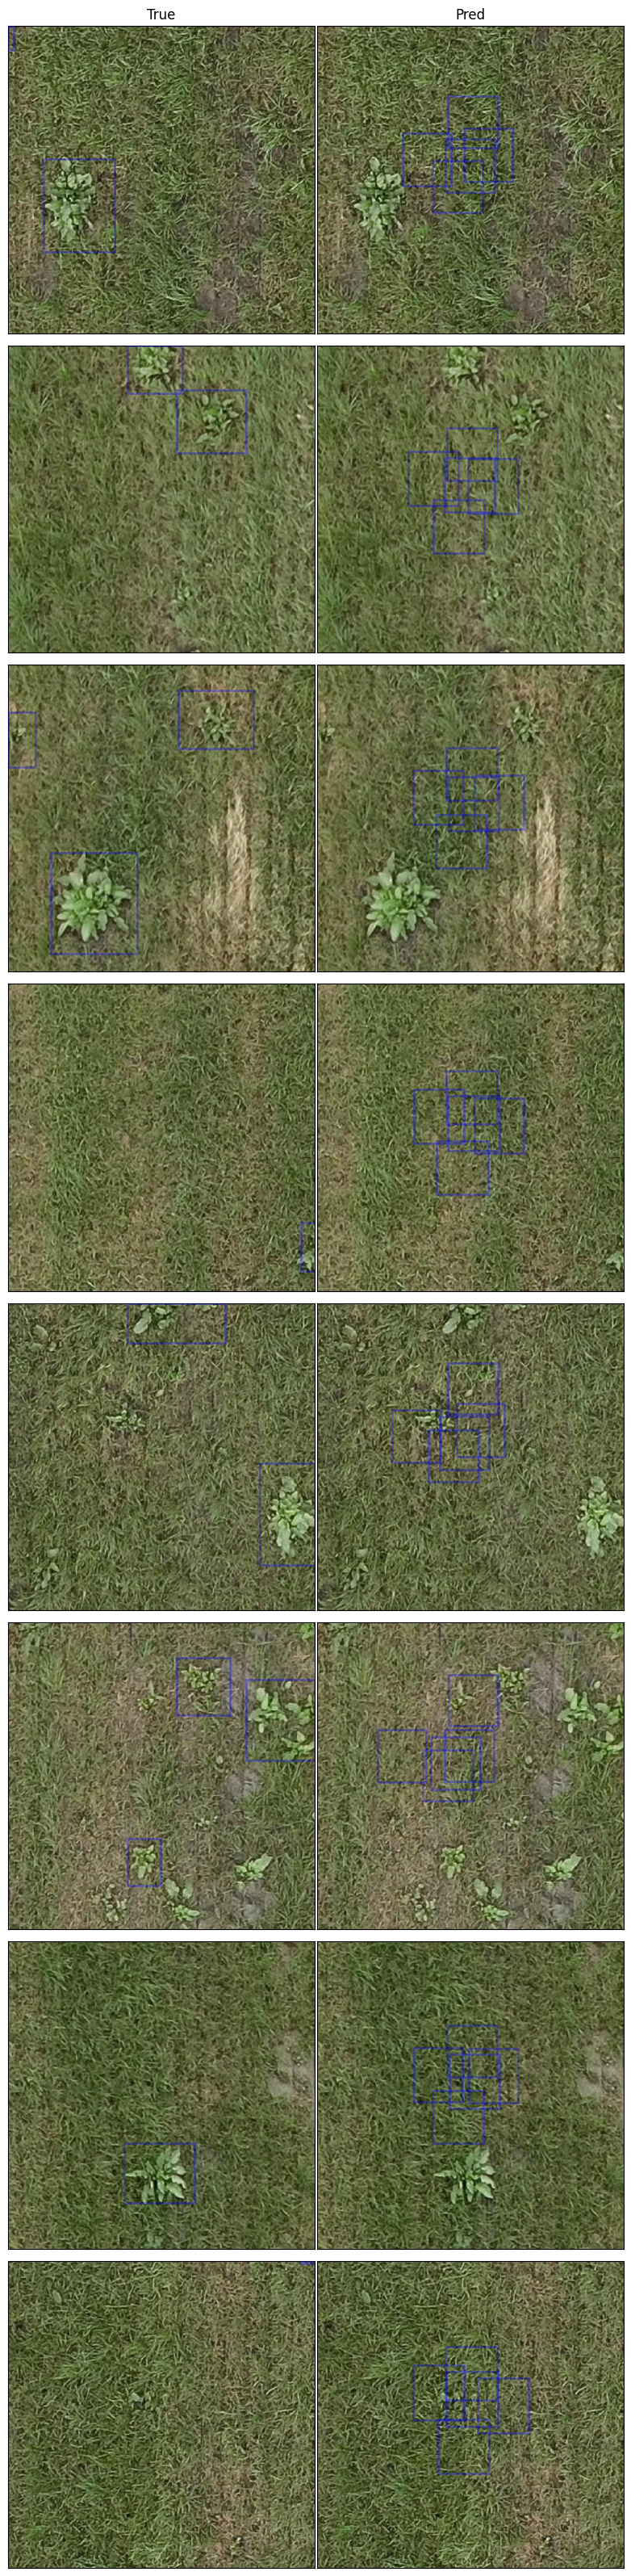

In [49]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for batch in test_dataloader:
    im, bboxes, a_labels, areas = batch  # Unpack the batch
    im = [img.to(device) for img in im]

    annot = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, a_labels)]
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :

        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)

        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

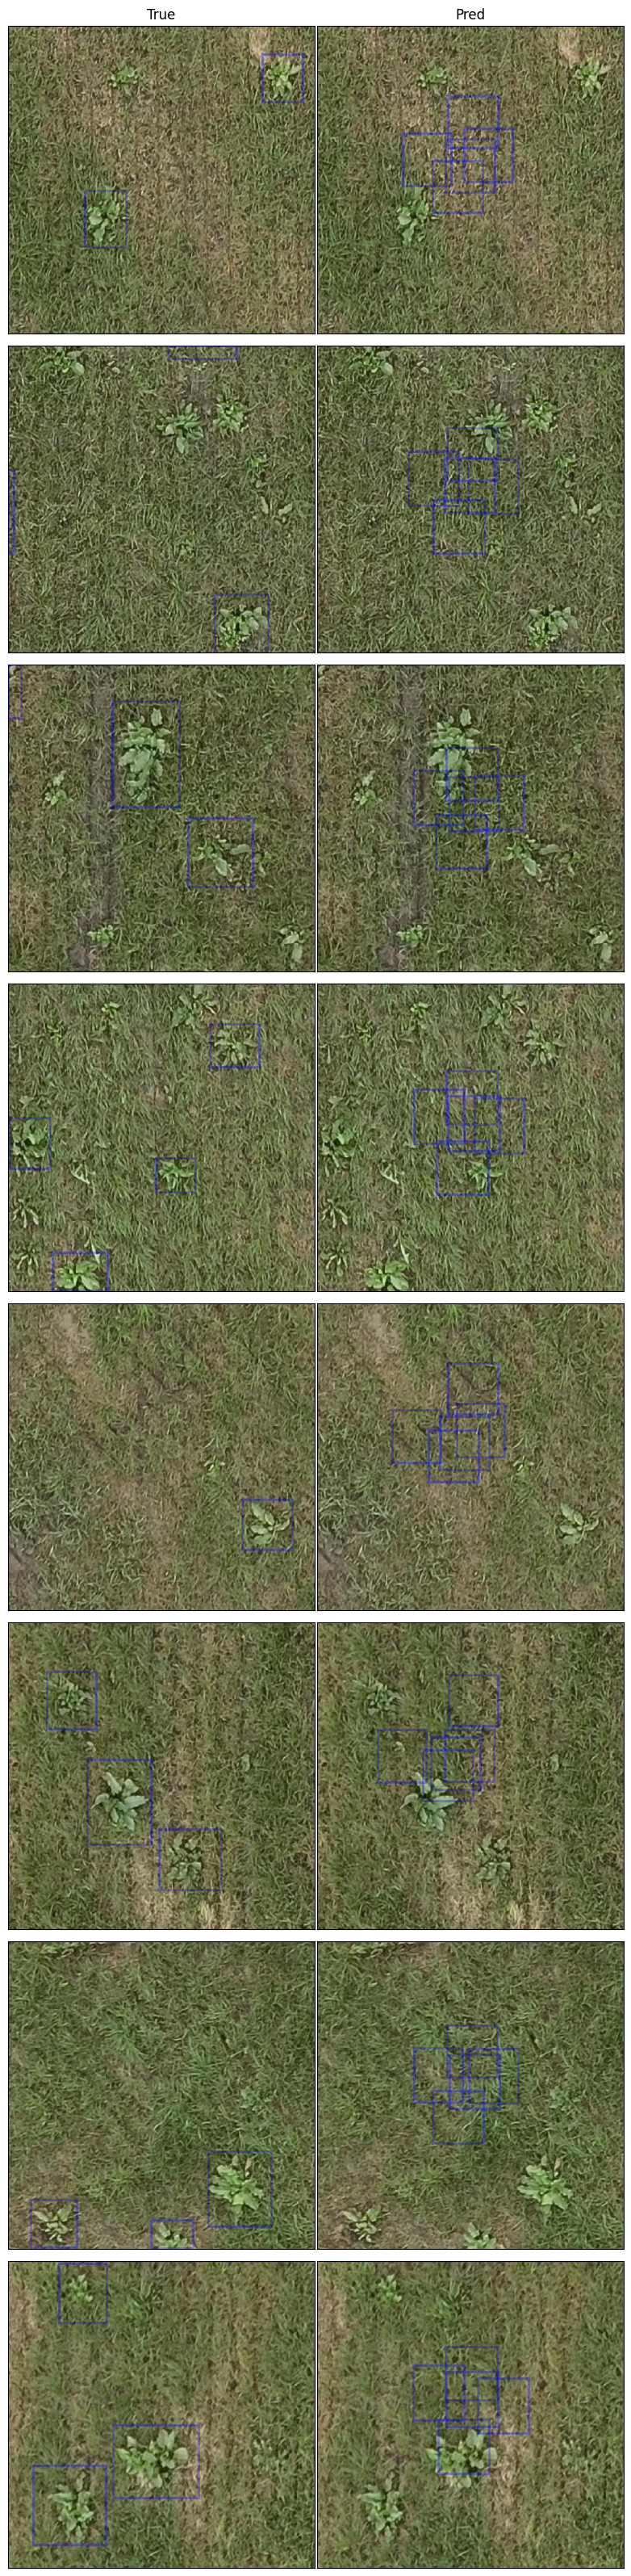

In [56]:
import random

nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

# Get the total number of batches
num_batches = len(test_dataloader)

# Select 4 random batch indices
random_batch_indices = random.sample(range(num_batches), 4)

batch_i = 0
batch_iter = iter(test_dataloader)  # Get an iterator over the DataLoader
for _ in random_batch_indices:
    try:
        batch = next(batch_iter)  # Get the next batch from the iterator
    except StopIteration:
        # If we run out of batches, restart the iterator
        batch_iter = iter(test_dataloader)
        batch = next(batch_iter)

    im, bboxes, a_labels, areas = batch  # Unpack the batch
    im = [img.to(device) for img in im]
    annot = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, a_labels)]

    pos = batch_i * 4 + 1
    for sample_i in range(len(im)):  # Process all samples in the batch
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)

        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2
        if pos > 32:  # 32 is the total number of subplots (8 rows * 2 columns * 2 images per row)
            break

    batch_i += 1
    if batch_i == 4:
        break

# Remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']
for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()